In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

# imports for azure time series anomaly detection
import os
from azure.ai.anomalydetector import AnomalyDetectorClient
from azure.ai.anomalydetector.models import DetectRequest, TimeSeriesPoint, TimeGranularity, AnomalyDetectorError
from azure.core.credentials import AzureKeyCredential

# imports for series2graph
import matplotlib.pyplot as plt

from series2graph import *
import sys  
sys.path.insert(0, '../src/hackathon')
from s2g_wrapper import *



### Generate data

In [123]:
# generate data 
date_rng = pd.date_range(start='01/01/2021', end='05/01/2021', freq='H')
df = pd.DataFrame(date_rng, columns=['date'])

# add a datetime column that will be of type datetime
df['datetime'] = pd.to_datetime(df['date'])

# convert to iso timestamp format
df['timestamp'] = df['datetime'].apply(datetime.isoformat,1) + 'Z'
# now make this column the index of the data frame
df = df.set_index('datetime')
# now the date column is not needed any more
df.drop(['date'], axis=1, inplace=True)


for index, element in df.iterrows():
    # between 22:00 and 06:00 - minimum activity
    if (index.hour >22 or index.hour <6):
        df.at[index,'value']=np.random.random()*10
    # between 06:00 and 08:00, 20:00-22:00 - slightly more
    elif ((index.hour >=20 and index.hour <=22) or (index.hour >=6 and index.hour <=8)):
        df.at[index,'value']=np.random.random()*10+10
    else:
        df.at[index,'value']=np.random.random()*20+20
    df.at[index,'intvalue']=int(df.at[index,'value'])

# need int for microsoft algorithm (actually not)
# df = df.astype({"intvalue": int})


df

,timestamp,value,intvalue
datetime,,,
2021-01-01 00:00:00,2021-01-01T00:00:00Z,2.184822,2.0
2021-01-01 01:00:00,2021-01-01T01:00:00Z,4.026510,4.0
2021-01-01 02:00:00,2021-01-01T02:00:00Z,1.346982,1.0
2021-01-01 03:00:00,2021-01-01T03:00:00Z,2.828448,2.0
2021-01-01 04:00:00,2021-01-01T04:00:00Z,1.357986,1.0
...,...,...,...
2021-04-30 20:00:00,2021-04-30T20:00:00Z,15.478425,15.0
2021-04-30 21:00:00,2021-04-30T21:00:00Z,13.524587,13.0
2021-04-30 22:00:00,2021-04-30T22:00:00Z,15.193013,15.0


<AxesSubplot:xlabel='datetime'>

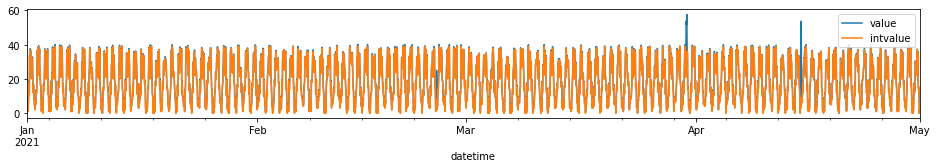

In [124]:
# add anomalies

# suspicious activity in the middle of the night 

df.at['2021-02-25 02:00:00','value'] = 25.0


#  high activity during the day - 3 hours

df.at['2021-03-30 15:00:00','value'] = 53.6
df.at['2021-03-30 16:00:00','value'] = 51.6
df.at['2021-03-30 17:00:00','value'] = 57.6

#  high activity at night - 1 hour

df.at['2021-04-15 02:00:00','value'] = 53.6


df.plot(figsize=(16,2))

### store data as CSV files (for use in other scripts)

In [125]:
# data for our own algorithm
df.to_csv("../DATA/test1.csv",columns=['timestamp','value'],index=False,header=True)
# data for azure algorithm - no headers, and must be integer
#intdf = df.astype({"value": int})
#df.to_csv("../DATA/test2.csv",columns=['timestamp','intvalue'],index=False,header=False)


### Execute Series2Graph algorithm (directly, no wrapper)

In [190]:
pattern_length = 24
query_length = 12
latent = None

#s2gw = S2gWrapper(df,query_length,pattern_length)
#scores = s2gw.calc('value')
#len(scores)
s2g = Series2Graph(pattern_length=pattern_length,latent=latent,rate=24)
s2g.fit(df,'value')
s2g.score(query_length)
scores = s2g.all_score
print(scores[0])
print(df['value'])
print(len(scores))

0.4298168312914293
datetime
2021-01-01 00:00:00     2.184822
2021-01-01 01:00:00     4.026510
2021-01-01 02:00:00     1.346982
2021-01-01 03:00:00     2.828448
2021-01-01 04:00:00     1.357986
                         ...    
2021-04-30 20:00:00    15.478425
2021-04-30 21:00:00    13.524587
2021-04-30 22:00:00    15.193013
2021-04-30 23:00:00     0.248406
2021-05-01 00:00:00     2.296295
Name: value, Length: 2881, dtype: float64
2835


Anomalies detected at:
2021-03-30T13:00:00Z
2021-03-30T14:00:00Z
2021-03-30T15:00:00Z
2021-03-30T16:00:00Z
2021-03-30T17:00:00Z
2021-03-30T18:00:00Z
2021-03-30T19:00:00Z
2021-03-30T20:00:00Z
2021-03-30T21:00:00Z
2021-03-30T22:00:00Z
2021-03-30T23:00:00Z
2021-03-31T00:00:00Z
2021-03-31T01:00:00Z
2021-03-31T02:00:00Z
2021-04-15T01:00:00Z
2021-04-15T02:00:00Z
2021-04-15T03:00:00Z
2021-04-15T04:00:00Z
2021-04-15T05:00:00Z
2021-04-15T06:00:00Z
2021-04-15T07:00:00Z
2021-04-15T08:00:00Z


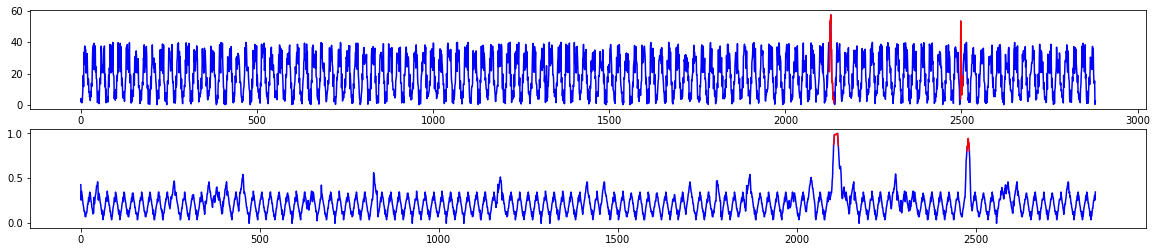

In [192]:
threshold = 0.8
anom_val = [];
anom_score = [];

#print(scores.size)
#print(df['value'].size)
#print(df['value'].size-scores.size)
#print(pattern_length//3+pattern_length+query_length+2)

start=pattern_length//3+2+query_length
end=pattern_length
#print(start+end)
# start + end = the difference between the size of the input and the number of scores.


for i in range(start):
    anom_val.append(np.nan)

print('Anomalies detected at:')
for i in range(len(scores)):
    if(scores[i] > threshold):
        print(df.iloc[i+start].timestamp)
        anom_val.append(df.iloc[i+start].value)
        anom_score.append(scores[i])
    else: 
        anom_val.append(np.nan)
        anom_score.append(np.nan)
        
for i in range(end):
    anom_val.append(np.nan)

fig,ax = plt.subplots(2,1,figsize=(20,4))

v=val+query_length
ax[0].plot(df['value'].values,color='blue')
ax[0].plot(anom_val[0:len(anom_val)],color='red')

ax[1].plot(scores,color='blue')
ax[1].plot(anom_score,color='red')
#ax[0].set_xlim(0,len(anom_score))
#ax[1].set_xlim(0,len(anom_score))



### Microsoft Azure time series anomaly detection algorithm

In [138]:
client = AnomalyDetectorClient(AzureKeyCredential("471b237892404a96ae736d613cb21221"), "https://mirit1.cognitiveservices.azure.com/")
series = []

for index, row in df.iterrows():
    series.append(TimeSeriesPoint(timestamp=row['timestamp'], value=row['value']))
request = DetectRequest(series=series, granularity=TimeGranularity.hourly)
print('Detecting anomalies in the entire time series.')

try:
    response = client.detect_entire_series(request)
except AnomalyDetectorError as e:
    print('Error code: {}'.format(e.error.code), 'Error message: {}'.format(e.error.message))
except Exception as e:
    print(e)
#print(response)




Detecting anomalies in the entire time series.


An anomaly was detected at:
2021-02-25T02:00:00Z
2021-03-30T15:00:00Z
2021-03-30T16:00:00Z
2021-03-30T17:00:00Z
2021-04-15T02:00:00Z


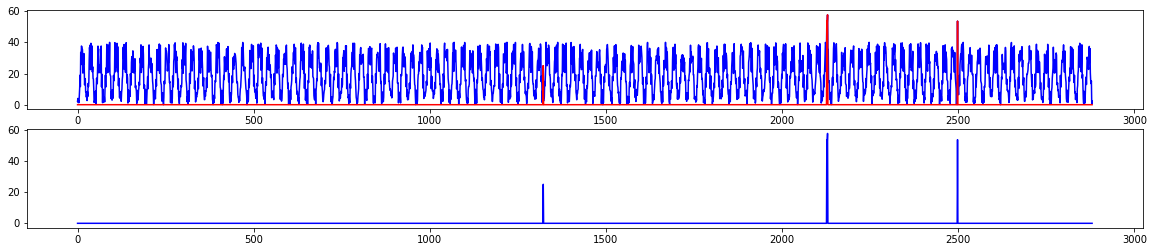

In [139]:
anomalies=[]
if any(response.is_anomaly):
    print('Anomalies detected at:')
    for i, value in enumerate(response.is_anomaly):
        if value:
            print(df.iloc[i].timestamp)
            anomalies.append(series[i].value)
        else:
            anomalies.append(0)
else:
    print('No anomalies were detected in the time series.')
anomalies_series = pd.Series(data=anomalies)

fig,ax = plt.subplots(2,1,figsize=(20,4))

ax[0].plot(df['value'].values[0:len(df['value'])],color='blue')
ax[0].plot(anomalies[0:len(anomalies)],color='red')

ax[1].plot(anomalies,color='blue')

